In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action = 'ignore')

import datetime

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering




In [2]:
#read crime data
missing_values = ['UNKNOWN', 'U']
df_crime = pd.read_csv("NYPD_Data_2021.csv", na_values=missing_values)

<h1>Data Inspection & Preprocessing</h1>

In [3]:
#check data
df_crime.info()

#check columns
print(df_crime.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449506 entries, 0 to 449505
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CMPLNT_NUM                449506 non-null  int64  
 1   ADDR_PCT_CD               449506 non-null  int64  
 2   BORO_NM                   448355 non-null  object 
 3   CMPLNT_FR_DT              449506 non-null  object 
 4   CMPLNT_FR_TM              449506 non-null  object 
 5   CMPLNT_TO_DT              409416 non-null  object 
 6   CMPLNT_TO_TM              409568 non-null  object 
 7   CRM_ATPT_CPTD_CD          449345 non-null  object 
 8   HADEVELOPT                1577 non-null    object 
 9   HOUSING_PSA               32583 non-null   float64
 10  JURISDICTION_CODE         449023 non-null  float64
 11  JURIS_DESC                449506 non-null  object 
 12  KY_CD                     449506 non-null  int64  
 13  LAW_CAT_CD                449506 non-null  o

In [4]:
df_crime.head(10)

#drop uncesseary(or may be too specific) data
df_crime.drop(['CMPLNT_NUM','JURISDICTION_CODE','PARKS_NM','STATION_NAME', 'PATROL_BORO',
                'TRANSIT_DISTRICT','HADEVELOPT','HOUSING_PSA','CRM_ATPT_CPTD_CD', 'New Georeferenced Column', 
               'JURIS_DESC','PD_CD','PD_DESC', 
                'X_COORD_CD', 'Y_COORD_CD', "CMPLNT_TO_DT", "CMPLNT_TO_TM"
                ],axis='columns', inplace=True)

#drop information of suspects
df_crime.drop(['SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX'], axis='columns', inplace=True)

<h2>Missing data</h2>

In [5]:
#search missing data
df_crime.isnull().sum().sort_values(ascending=False)

VIC_RACE             125810
VIC_AGE_GROUP        116573
LOC_OF_OCCUR_DESC     74263
PREM_TYP_DESC          1270
BORO_NM                1151
OFNS_DESC                 9
ADDR_PCT_CD               0
CMPLNT_FR_DT              0
CMPLNT_FR_TM              0
KY_CD                     0
LAW_CAT_CD                0
RPT_DT                    0
VIC_SEX                   0
Latitude                  0
Longitude                 0
Lat_Lon                   0
dtype: int64

In [6]:
#drop na value rows with important information
important_feature = ['OFNS_DESC', 'VIC_RACE', 
                     'VIC_SEX', 'VIC_AGE_GROUP',
                     'CMPLNT_FR_DT','CMPLNT_FR_TM', 
                     'PREM_TYP_DESC','LOC_OF_OCCUR_DESC']

df_crime = df_crime.dropna(subset=important_feature, how='any')

len(df_crime)

271590

In [7]:
#fill BORO_NM with precinct num
precincts = {
    "MANHATTAN" : [1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34],
    "BRONX": [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52],
    "BROOKLYN": [60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 88, 90, 94],
    "QUEENS" : [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115],
    "STATEN ISLAND": [120, 121, 122, 123]
}

for i in df_crime.loc[df_crime['BORO_NM'].isna()].index:
    for key in precincts.keys():
        if df_crime.loc[i,['ADDR_PCT_CD']].item() in precincts[key]:
            df_crime.loc[i,['BORO_NM']] = key


df_crime['BORO_NM'].value_counts()


BROOKLYN         80275
QUEENS           62370
BRONX            60864
MANHATTAN        55076
STATEN ISLAND    13005
Name: BORO_NM, dtype: int64

In [8]:
#check if any NaN data is left
df_crime.isnull().any()

ADDR_PCT_CD          False
BORO_NM              False
CMPLNT_FR_DT         False
CMPLNT_FR_TM         False
KY_CD                False
LAW_CAT_CD           False
LOC_OF_OCCUR_DESC    False
OFNS_DESC            False
PREM_TYP_DESC        False
RPT_DT               False
VIC_AGE_GROUP        False
VIC_RACE             False
VIC_SEX              False
Latitude             False
Longitude            False
Lat_Lon              False
dtype: bool

<h3>Text Preprocessing & Grouping</h3>

In [9]:
#group crime
violent = ['MURDER & NON-NEGL. MANSLAUGHTER','HOMICIDE-NEGLIGENT-VEHICLE', 'MURDER & NON-NEGL. MANSLAUGHTE',
    'HOMICIDE-NEGLIGENT,UNCLASSIFIED','HOMICIDE-NEGLIGENT-VEHICLE','HOMICIDE-NEGLIGENT,UNCLASSIFIE', 
    'FELONY ASSAULT', 'ASSAULT 3 & RELATED OFFENSES','JOSTLING', 'RAPE','SEX CRIMES','FORCIBLE TOUCHING',
    'ROBBERY','OFFENSES RELATED TO CHILDREN','KIDNAPPING & RELATED OFFENSES','KIDNAPPING',
    "OFFENSES AGAINST THE PERSON", "ENDAN WELFARE INCOMP", "DISORDERLY CONDUCT", "CHILD ABANDONMENT/NON SUPPORT"]

traffic = ['OTHER TRAFFIC INFRACTION','VEHICLE AND TRAFFIC LAWS','INTOXICATED & IMPAIRED DRIVING',
           'INTOXICATED/IMPAIRED DRIVING','UNAUTHORIZED USE OF A VEHICLE 3 (UUV)','PARKING OFFENSES',
           'UNAUTHORIZED USE OF A VEHICLE']

non_violent = ['THEFT-FRAUD','FORGERY','FRAUDS','OFFENSES INVOLVING FRAUD','FRAUDULENT ACCOSTING','ARSON',
               'CRIMINAL TRESPASS','DANGEROUS WEAPONS','UNLAWFUL POSS. WEAP. ON SCHOOL GROUNDS',
               'UNLAWFUL POSS. WEAP. ON SCHOOL','Tresspassing','HARRASSMENT 2','OFFENSES AGAINST PUBLIC SAFETY',
               'HARASSMENT','PROSTITUTION & RELATED OFFENSES', 'CRIMINAL MISCHIEF & RELATED OF', "MISCELLANEOUS PENAL LAW",
               "OFF. AGNST PUB ORD SENSBLTY &", "OFFENSES AGAINST PUBLIC ADMINI", "ADMINISTRATIVE CODE", "ANTICIPATORY OFFENSES",
               "GAMBLING", "ALCOHOLIC BEVERAGE CONTROL LAW", "LOITERING/GAMBLING (CARDS, DIC", "ESCAPE 3"]

theft = ['GRAND LARCENY','PETIT LARCENY','OTHER OFFENSES RELATED TO THEF','THEFT OF SERVICES',
         'OTHER OFFENSES RELATED TO THEFT', 'PETIT LARCENY','GRAND LARCENY OF MOTOR VEHICLE',
         'POSSESSION OF STOLEN PROPERTY','POSSESSION OF STOLEN PROPERTY 5','BURGLARY', "PETIT LARCENY OF MOTOR VEHICLE", "BURGLAR'S TOOLS"]

drugs = ['DANGEROUS DRUGS','LOITERING FOR DRUG PURPOSES']

unclassified = ["NYS LAWS-UNCLASSIFIED FELONY", "OTHER STATE LAWS (NON PENAL LA", "AGRICULTURE & MRKTS LAW-UNCLASSIFIED", "OTHER STATE LAWS", 
                "NYS LAWS-UNCLASSIFIED VIOLATION"]



crime_group = []

for row in df_crime.OFNS_DESC:
    if (row in violent) == True:
        crime_group.append('VIOLENT')

    elif (row in traffic) == True:
        crime_group.append('TRAFFIC')

    elif (row in non_violent) == True:
        crime_group.append('NON_VIOLENT')

    elif (row in theft) == True:
        crime_group.append('THEFT')

    elif (row in drugs) == True:
        crime_group.append('DRUGS')

    elif (row in unclassified) == True:
        crime_group.append('UNCLASSIFIED')

    else :
        crime_group.append('UNCLASSIFIED')

df_crime["CM_GROUP"] = crime_group
df_crime.groupby("CM_GROUP")

#drop unclassdied information
cm_group_unclassified = df_crime[df_crime['CM_GROUP'] == 'UNCLASSIFIED'].index
df_crime.drop(cm_group_unclassified, inplace=True)

df_crime["CM_GROUP"].value_counts()


NON_VIOLENT    120646
THEFT           77657
VIOLENT         70626
TRAFFIC          2371
DRUGS              54
Name: CM_GROUP, dtype: int64

In [10]:
df_crime = df_crime.replace({'STREET':'STREET','RESIDENCE - APT. HOUSE': 'RESIDENCE',
                        'PARKING LOT/GARAGE (PUBLIC)':'PUBLIC_PLACE',
                         'RESIDENCE-HOUSE' : 'RESIDENCE',
                         'DEPARTMENT STORE':'STORE',
                         'RESIDENCE - PUBLIC HOUSING':'RESIDENCE',
                         'HOMELESS SHELTER':'RESIDENCE',
                         'TRANSIT - NYC SUBWAY':'TRANSIT',
                         'HOTEL/MOTEL':'RESIDENCE',
                         'CHAIN STORE':'STORE',
                         'RESTAURANT/DINER':'RESTAURANT',
                         'GYM/FITNESS FACILITY':'STORE',
                         'SMALL MERCHANT':'STORE_CAUTION',
                         'GROCERY/BODEGA':'STORE',
                         'OTHER':'OTHER',
                         'PUBLIC BUILDING':'PUBLIC_PLACE',
                         'DRUG STORE':'STORE_CAUTION',
                         'PARK/PLAYGROUND':'PUBLIC_PLACE',
                         'CLOTHING/BOUTIQUE':'STORE',
                         'COMMERCIAL BUILDING':'PUBLIC_PLACE',
                         'HIGHWAY/PARKWAY':'VEHICLE',
                         'BANK':'PUBLIC_BUILDING_SAFTY',
                         'MAILBOX INSIDE':'OTHER',
                         'FAST FOOD':'STORE',
                         'DOCTOR/DENTIST OFFICE':'STORE',
                         'DRY CLEANER/LAUNDRY':'STORE',
                         'FOOD SUPERMARKET':'STORE',
                         'HOSPITAL':'PUBLIC_BUILDING_SAFTY',
                         'AIRPORT TERMINAL':'PUBLIC_BUILDING_SAFTY',
                         'CANDY STORE':'STORE',
                          'BAR/NIGHT CLUB':'STORE_CAUTION',
                         'STORE UNCLASSIFIED':'STORE',
                          'PARKING LOT/GARAGE (PRIVATE)':'PUBLIC_PLACE',
                          'PUBLIC SCHOOL':'PUBLIC_BUILDING_SAFTY',
                           'TELECOMM. STORE':'STORE',
                          'CHECK CASHING BUSINESS':'STORE_CAUTION',
                          'BEAUTY & NAIL SALON':'STORE',
                          'BUS (NYC TRANSIT)':'VEHICLE',
                          'LIQUOR STORE':'STORE_CAUTION',
                            'CONSTRUCTION SITE':'STREET','BUS STOP':'TRANSIT','BUS (OTHER)':'VEHICLE',
                        'CHURCH':'PUBLIC_PLACE',
                         'FACTORY/WAREHOUSE':'OTHER',
                         'TAXI/LIVERY (UNLICENSED)':'VEHICLE',
                         'GAS STATION':'STORE_CAUTION',
                        'OPEN AREAS (OPEN LOTS)':'STREET',
                          'ATM':'STREET',
                         'VARIETY STORE':'STORE',
                         'SHOE':'STORE',
                         'MAILBOX OUTSIDE':'STREET',
                         'SOCIAL CLUB/POLICY':'RESTAURANT',
                         'BOOK/CARD':'STORE',
                        'BUS TERMINAL':'TRANSIT',
                        'CEMETERY':'STREET',
                         'TUNNEL':'STREET',
                         'MARINA/PIER':'STREET',
                         'OTHER HOUSE OF WORSHIP':'PUBLIC_PLACE',
                         'BRIDGE':'STREET',
                         'TAXI (YELLOW LICENSED)':'VEHICLE',
                         'SYNAGOGUE':'PUBLIC_PLACE',
                         'MOSQUE':'PUBLIC_PLACE',
                         'FERRY/FERRY TERMINAL':'TRANSIT',
                         'LOAN COMPANY':'STORE_CAUTION',
                         'DAYCARE FACILITY':'PUBLIC_BUILDING_SAFTY',
                         'PHOTO/COPY':'STORE',
                         'ABANDONED BUILDING':'STREET',
                         'TRAMWAY':'TRANSIT',
                         'JEWELRY':'STORE_CAUTION',
                         'VIDEO STORE':'STORE',
                        'TRANSIT FACILITY (OTHER)':'TRANSIT',
                        'STORAGE FACILITY':'OTHER',
                        'TAXI (LIVERY LICENSED)':'TRANSIT',
                        'PRIVATE/PAROCHIAL SCHOOL':'PUBLIC_BUILDING_SAFTY'})
df_crime.PREM_TYP_DESC.unique()


df_crime.PREM_TYP_DESC.value_counts()


RESIDENCE                171862
STREET                    60789
STORE                     13409
PUBLIC_PLACE               8723
OTHER                      5424
STORE_CAUTION              3965
PUBLIC_BUILDING_SAFTY      3814
RESTAURANT                 2626
TRANSIT                     453
VEHICLE                     289
Name: PREM_TYP_DESC, dtype: int64

In [11]:
df_crime = df_crime.replace({'BLACK HISPANIC':'BLACK','ASIAN / PACIFIC ISLANDER':'ASIAN',
                        'WHITE HISPANIC':'WHITE'})
df_crime.VIC_RACE.value_counts()

WHITE                             123356
BLACK                             116210
ASIAN                              30569
AMERICAN INDIAN/ALASKAN NATIVE      1219
Name: VIC_RACE, dtype: int64

<AxesSubplot:title={'center':'Total Crime Events by Month'}, xlabel='month'>

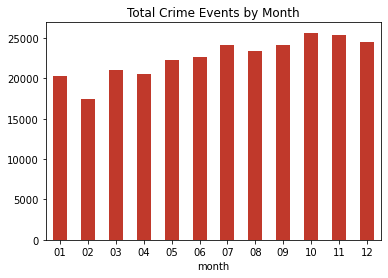

In [12]:
#reports by month
df_crime['month'] = df_crime['CMPLNT_FR_DT'].str.findall('(\d{2})').apply(lambda x: x[0])
df_crime.groupby('month').size().plot(kind = 'bar', title ='Total Crime Events by Month', color = '#C0392B',rot=0)

,time_cut
14~16,30613
16~18,30312
10~12,29891
18~20,28702
0~2,28668
12~14,27836
20~22,25099
8~10,23709
6~8,16233
22~24,11029


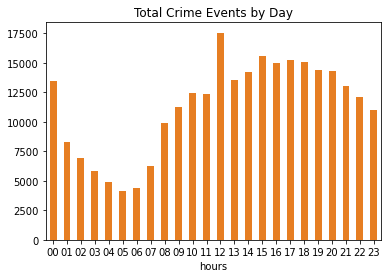

In [13]:
#reports by hour
df_crime['time'] = df_crime['CMPLNT_FR_TM'].str.findall('(\d{2})').apply(lambda x: x[0])
df_crime.groupby('time').size().plot(kind = 'bar', title ='Total Crime Events by Day', color = '#E67E22', xlabel = 'hours',rot=0)

df_crime['time'] = pd.to_numeric(df_crime['time'])

df_crime['time_cut'] = pd.cut(df_crime.time,bins=[-1,2,4,6,8,10,12,14,16,18,20,22,25],
                              labels=['0~2','2~4','4~6','6~8','8~10','10~12','12~14','14~16','16~18','18~20','20~22','22~24'])


df_crime.time_cut.value_counts().to_frame().style.background_gradient(cmap='summer')

array([<AxesSubplot:ylabel='CM_GROUP'>], dtype=object)

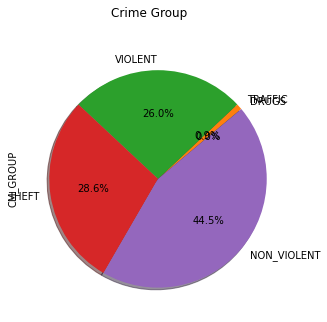

In [14]:
#Crime group pie chart
df_crime['CM_GROUP'].value_counts().sort_values().plot(kind='pie', subplots=True, shadow = True,startangle=40,
figsize=(10,5), autopct='%1.1f%%', title = 'Crime Group')

In [15]:
#Crime group by PREM_TYP_DESC
df_crime['CM_GROUP'].unique()

array(['NON_VIOLENT', 'VIOLENT', 'THEFT', 'TRAFFIC', 'DRUGS'],
      dtype=object)

array([<AxesSubplot:ylabel='PREM_TYP_DESC'>], dtype=object)

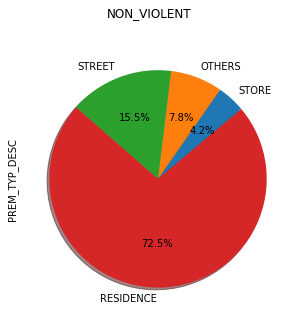

In [16]:
data_non = df_crime[df_crime['CM_GROUP'].str.contains("NON_VIOLENT")]
data_non['PREM_TYP_DESC'].value_counts().sort_values()
mask = df_crime['PREM_TYP_DESC'].isin(['RESIDENCE','STREET','STORE'])
data_top3 = data_non[mask]
data_others = data_non[~mask]
data_others['PREM_TYP_DESC']='OTHERS'
result1 = data_top3.append(data_others)
result1['PREM_TYP_DESC'].value_counts().sort_values().plot(kind='pie', subplots=True, shadow = True,startangle=40,
figsize=(10,5), autopct='%1.1f%%', title = 'NON_VIOLENT')

array([<AxesSubplot:ylabel='PREM_TYP_DESC'>], dtype=object)

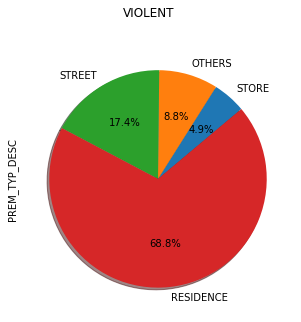

In [17]:
data_non = df_crime[df_crime['CM_GROUP'].str.contains("VIOLENT")]
data_non['PREM_TYP_DESC'].value_counts().sort_values()
mask = df_crime['PREM_TYP_DESC'].isin(['RESIDENCE','STREET','STORE'])
data_top3 = data_non[mask]
data_others = data_non[~mask]
data_others['PREM_TYP_DESC']='OTHERS'
result1 = data_top3.append(data_others)
result1['PREM_TYP_DESC'].value_counts().sort_values().plot(kind='pie', subplots=True, shadow = True,startangle=40,
figsize=(10,5), autopct='%1.1f%%', title = 'VIOLENT')

array([<AxesSubplot:ylabel='PREM_TYP_DESC'>], dtype=object)

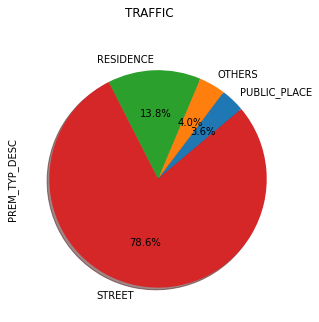

In [18]:
data_non = df_crime[df_crime['CM_GROUP'].str.contains("TRAFFIC")]
data_non['PREM_TYP_DESC'].value_counts().sort_values()
mask = df_crime['PREM_TYP_DESC'].isin(['RESIDENCE','STREET','PUBLIC_PLACE'])
data_top3 = data_non[mask]
data_others = data_non[~mask]
data_others['PREM_TYP_DESC']='OTHERS'
result1 = data_top3.append(data_others)
result1['PREM_TYP_DESC'].value_counts().sort_values().plot(kind='pie', subplots=True, shadow = True,startangle=40,
figsize=(10,5), autopct='%1.1f%%', title = 'TRAFFIC')

array([<AxesSubplot:ylabel='PREM_TYP_DESC'>], dtype=object)

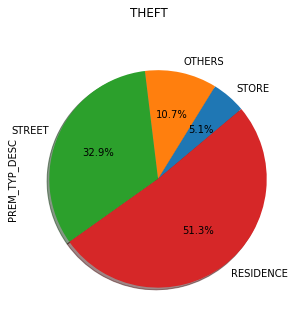

In [19]:
data_non = df_crime[df_crime['CM_GROUP'].str.contains("THEFT")]
data_non['PREM_TYP_DESC'].value_counts().sort_values()
mask = df_crime['PREM_TYP_DESC'].isin(['RESIDENCE','STREET','STORE'])
data_top3 = data_non[mask]
data_others = data_non[~mask]
data_others['PREM_TYP_DESC']='OTHERS'
result1 = data_top3.append(data_others)
result1['PREM_TYP_DESC'].value_counts().sort_values().plot(kind='pie', subplots=True, shadow = True,startangle=40,
figsize=(10,5), autopct='%1.1f%%', title = 'THEFT')

array([<AxesSubplot:ylabel='PREM_TYP_DESC'>], dtype=object)

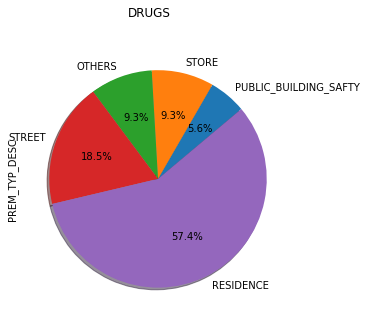

In [20]:
data_non = df_crime[df_crime['CM_GROUP'].str.contains("DRUGS")]
data_non['PREM_TYP_DESC'].value_counts().sort_values()
mask = df_crime['PREM_TYP_DESC'].isin(['RESIDENCE','STREET','STORE','PUBLIC_BUILDING_SAFTY'])
data_top3 = data_non[mask]
data_others = data_non[~mask]
data_others['PREM_TYP_DESC']='OTHERS'
result1 = data_top3.append(data_others)
result1['PREM_TYP_DESC'].value_counts().sort_values().plot(kind='pie', subplots=True, shadow = True,startangle=40,
figsize=(10,5), autopct='%1.1f%%', title = 'DRUGS')

In [21]:
#Crime group by Borough

<h2>Module for Regression (Open source SW)</h2>

<h3>Check for</h3>

Ordinal, Label encoder,

Standard, Robust, Maxabs scaler,

Linear, Polynomial, DecisionTreeClassifier Regression

In [22]:
#return 2 df each encoded by ordinal encoder, label encoder
def ordinal_label_encoder(df):
    df_ordinal = df.copy()
    df_label = df.copy()

    ord_enc = preprocessing.OrdinalEncoder()
    label_enc = preprocessing.LabelEncoder()

    df_categorical = df.select_dtypes(include=["object", "string", 'category'])

    df_numeric = df.select_dtypes(include=["int64", "float64"])

    #Convert categorical columns with ordinal encoder
    df_ordinal[df_categorical.columns] = df_categorical
    ord_enc.fit(df_categorical)

    df_ordinal = df_ordinal.reset_index() 
    df_ordinal[df_categorical.columns]= pd.DataFrame(ord_enc.transform(df_categorical))
    df_ordinal[df_categorical.columns]


    #Convert categorical columns with label encoder
    df_label = df_label.reset_index()

    for column in df_categorical.columns:
        label_enc.fit(df_categorical[column])
        df_label[column] = pd.DataFrame(label_enc.transform(df_categorical[column]))

    return df_ordinal, df_label

def regression_model(scaler, X, y, model, train_size_val, random_state_val):
    scaler.fit(X)
    X = scaler.transform(X)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_size_val, stratify=y, random_state=random_state_val)

    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)

    return accuracy

def regression_best_score (df, selected_features, target, train_size_val, random_state_val):

    df_ordinal, df_label = ordinal_label_encoder(df)

    X_by_encoder = {'OrdinalEncdoer': df_ordinal[selected_features], 
                'LabelEncoder': df_label[selected_features]}

    y_by_encoder = {'OrdinalEncdoer' : df_ordinal[target],
                    'LabelEncoder': df_label[target]}

    scalers = {'StandardScaler': preprocessing.StandardScaler(),
                'RobustScaler' : preprocessing.RobustScaler(),
                'MaxabsScaler' :preprocessing.MaxAbsScaler()}

    model_by_regression = {'LinearRegression' : LinearRegression(),
                            'PolynomialRegression': Pipeline([('poly', PolynomialFeatures(degree=2)), 
                                                              ('linear', LinearRegression(fit_intercept=False))]),
                            'DecisionTreeClassifier' : DecisionTreeClassifier()
                            }

    best = {
        'a':-1,
        'scaler':"not assigned yet",
        'encoder':"not assigned yet",
        'regression':"not assigned yet"
    }

    

    for s in scalers.keys():
        for e in X_by_encoder.keys():
            for r in model_by_regression.keys():
                accuracy = regression_model(scalers[s], X_by_encoder[e], y_by_encoder[e], model_by_regression[r], train_size_val, random_state_val)
                if best['a'] < accuracy:
                    best['a'] = accuracy
                    best['scaler'], best['encoder'], best['regression'] = s, e, r

    return best['a'], best['scaler'], best['encoder'], best['regression']

<h1>Check regression with our regression function</h1>

In [23]:
#regrssion for target Crime group
selected_features = ['ADDR_PCT_CD','BORO_NM', 
                     'Latitude','Longitude',
                     'VIC_AGE_GROUP', 'VIC_SEX','VIC_RACE', 
                     'time_cut' , 'month']

target = ['CM_GROUP']

print("Target: Crime Group, train size : 0.8, random state : 1")
print(regression_best_score(df_crime, selected_features, target, 0.8, 1))
print("\n")
print("Target: Crime Group, train size : 0.7, random state : 1")
print(regression_best_score(df_crime, selected_features, target, 0.7, 1))

print("\n")
print("\n")
selected_features = ['ADDR_PCT_CD', 'BORO_NM', 
                     'Latitude','Longitude',
                     'VIC_AGE_GROUP', 'VIC_SEX','VIC_RACE', 
                     'month', 'CM_GROUP']
target = ['time_cut']

print("Target: Time cut, train size : 0.8, random state : 1")
print(regression_best_score(df_crime, selected_features, target, 0.8, 1))
print("\n")
print("Target: Time cut, train size : 0.7, random state : 1")
print(regression_best_score(df_crime, selected_features, target, 0.7, 1))

Target: Crime Group, train size : 0.8, random state : 1
(0.40551583718744816, 'StandardScaler', 'OrdinalEncdoer', 'DecisionTreeClassifier')


Target: Crime Group, train size : 0.7, random state : 1
(0.4059426790490029, 'MaxabsScaler', 'OrdinalEncdoer', 'DecisionTreeClassifier')




Target: Time cut, train size : 0.8, random state : 1
(0.1072534134252179, 'RobustScaler', 'OrdinalEncdoer', 'DecisionTreeClassifier')


Target: Time cut, train size : 0.7, random state : 1
(0.109814264956725, 'StandardScaler', 'OrdinalEncdoer', 'DecisionTreeClassifier')


<h1>Clustering</h1>

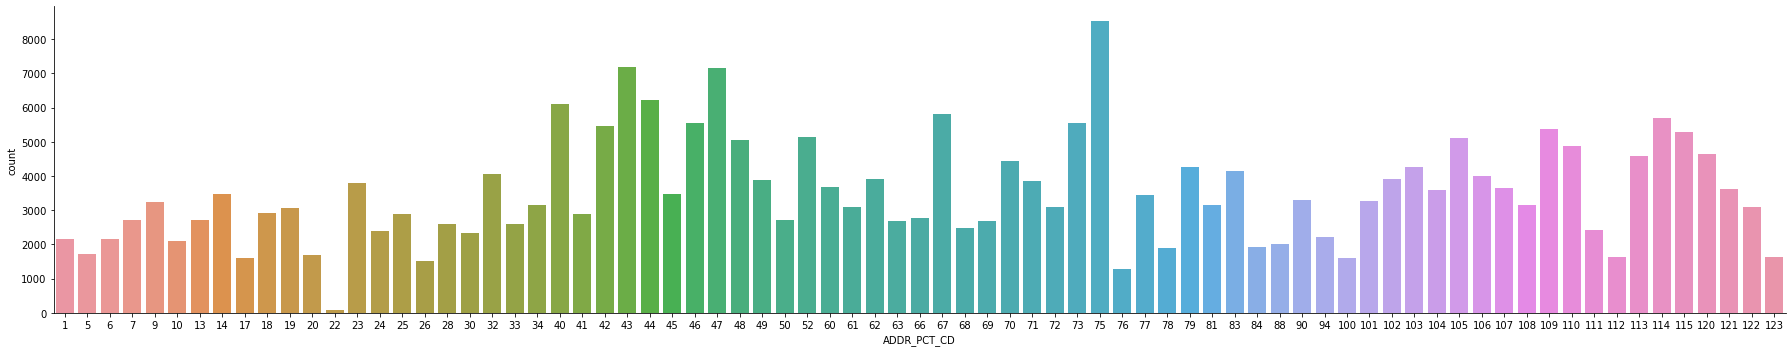

In [24]:
#inspection with ADDR_PCT_CD value
sns.catplot(data = df_crime, kind = 'count', x = 'ADDR_PCT_CD', aspect = 5)

<function matplotlib.pyplot.show(close=None, block=None)>

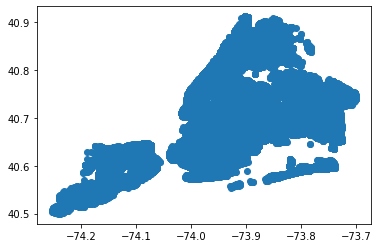

In [25]:
lat = df_crime['Latitude'].dropna().values
long = df_crime['Longitude'].dropna().values

plt.scatter(long, lat)
plt.show

In [26]:
n = 5

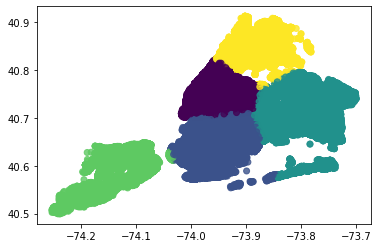

In [27]:
nyc_geo = np.vstack((long, lat)).T

geo_cluster_model = KMeans(n_clusters = n)
geo_cluster_model.fit(nyc_geo)

geo_clusters = geo_cluster_model.labels_
geo_centroids = geo_cluster_model.cluster_centers_

plt.scatter(long, lat, c = geo_clusters, alpha = 0.8)
plt.show()

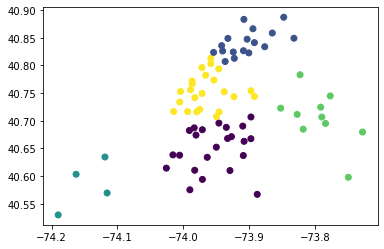

0.42336282117362833


In [28]:
#Geographical coordinate , ADDR_PCT_CD clustering
precinct_geo = df_crime[['ADDR_PCT_CD', 'Longitude', 'Latitude']].sort_values('ADDR_PCT_CD').dropna().drop_duplicates('ADDR_PCT_CD')

precinct_lat = precinct_geo['Latitude'].values
precinct_long = precinct_geo['Longitude'].values

nyc_geo = np.vstack((precinct_long, precinct_lat)).T

#Scale 
scaler = StandardScaler()
scaler.fit(nyc_geo)
nyc_geo_cc_sampled = scaler.transform(nyc_geo)

geo_cluster_cc_model = KMeans(n_clusters = n)
geo_cluster_cc_model.fit(nyc_geo_cc_sampled)

geo_cc_clusters = geo_cluster_cc_model.labels_
geo_cc_centroids = geo_cluster_cc_model.cluster_centers_

plt.scatter(precinct_long, precinct_lat, c = geo_cc_clusters)
plt.show()

labels = geo_cluster_cc_model.labels_
score = silhouette_score(nyc_geo,labels, metric='euclidean')
print(score)

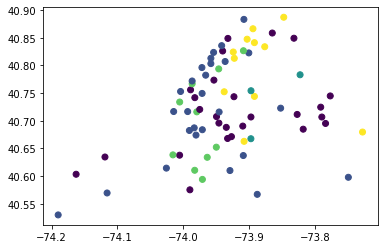

0.19093532650681672


In [29]:
#Crime group, ADDR_PCT_CD clustering

precinct_group = pd.crosstab(df_crime['ADDR_PCT_CD'], df_crime['CM_GROUP'])
precinct_group = precinct_group.reset_index()

nyc_violent = precinct_group['VIOLENT'].values
nyc_non_violent = precinct_group['NON_VIOLENT'].values
nyc_theft = precinct_group['THEFT'] .values
nyc_traffic = precinct_group['THEFT'] .values
nyc_drugs = precinct_group['DRUGS'].values
nyc_group = np.vstack((nyc_violent, nyc_non_violent, nyc_theft, nyc_traffic, nyc_drugs)).T

scaler = StandardScaler()
nyc_group_sampled = scaler.fit_transform(nyc_group)

precinct_group_cluster_model = KMeans(n_clusters = n)
precinct_group_cluster_model.fit(nyc_group_sampled)

precinct_group_clusters = precinct_group_cluster_model.labels_
precinct_group_centroids = precinct_group_cluster_model.cluster_centers_

plt.scatter(precinct_long, precinct_lat, c = precinct_group_clusters)
plt.show()

labels = precinct_group_cluster_model.labels_
score = silhouette_score(nyc_group,labels, metric='euclidean')
print(score)

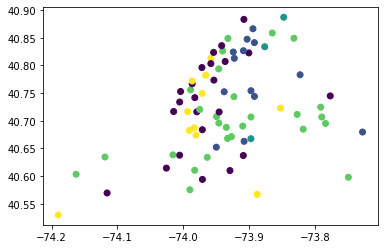

0.43909117578187906


In [30]:
#Victim age, ADDR_PCT_CD clustering

precinct_vic_age = pd.crosstab(df_crime['ADDR_PCT_CD'], df_crime['VIC_AGE_GROUP'])
precinct_vic_age = precinct_vic_age.reset_index()

nyc_18_24 = precinct_vic_age['18-24'].values
nyc_25_44 = precinct_vic_age['25-44'].values
nyc_45_64 = precinct_vic_age['45-64'] .values
nyc_lt_18 = precinct_vic_age['<18'] .values
nyc_vic_age = np.vstack((nyc_18_24, nyc_25_44, nyc_45_64, nyc_lt_18)).T

scaler = StandardScaler()
nyc_vic_age_sampled = scaler.fit_transform(nyc_vic_age)

precinct_vic_age_cluster_model = KMeans(n_clusters = n)
precinct_vic_age_cluster_model.fit(nyc_vic_age)

precinct_vic_age_clusters = precinct_vic_age_cluster_model.labels_
precinct_vic_age_centroids = precinct_vic_age_cluster_model.cluster_centers_

plt.scatter(precinct_long, precinct_lat, c = precinct_vic_age_clusters)
plt.show()

labels = precinct_vic_age_cluster_model.labels_
score = silhouette_score(nyc_vic_age,labels, metric='euclidean')
print(score)

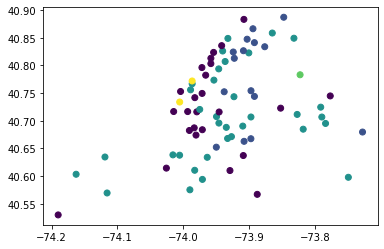

0.05352587215068502


In [31]:
#Victim sex, ADDR_PCT_CD clustering
precinct_vic_sex = pd.crosstab(df_crime['ADDR_PCT_CD'], df_crime['VIC_SEX'])
precinct_vic_sex = precinct_vic_sex.reset_index()

nyc_males = precinct_vic_sex['M'].values
nyc_females = precinct_vic_sex['F'].values
nyc_business = precinct_vic_sex['D'] .values
nyc_vic_sex = np.vstack((nyc_males, nyc_females, nyc_business)).T

scaler = StandardScaler()
nyc_vic_sex_sampled = scaler.fit_transform(nyc_vic_sex)

precinct_vic_sex_cluster_model = KMeans(n_clusters = n)
precinct_vic_sex_cluster_model.fit(nyc_vic_sex_sampled)

precinct_vic_sex_clusters = precinct_vic_sex_cluster_model.labels_
precinct_vic_sex_centroids = precinct_vic_sex_cluster_model.cluster_centers_

plt.scatter(precinct_long, precinct_lat, c = precinct_vic_sex_clusters)
plt.show()

labels = precinct_vic_sex_cluster_model.labels_
score = silhouette_score(nyc_vic_sex,labels, metric='euclidean')
print(score)

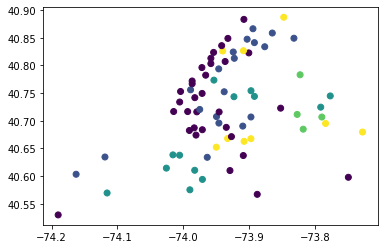

0.22610867499805573


In [32]:
#Victim race, ADDR_PCT_CD clustering
precinct_vic_sex = pd.crosstab(df_crime['ADDR_PCT_CD'], df_crime['VIC_RACE'])
precinct_vic_sex = precinct_vic_sex.reset_index()

nyc_black = precinct_vic_sex['BLACK'].values
nyc_white = precinct_vic_sex['WHITE'] .values
nyc_asian_pa = precinct_vic_sex['ASIAN'] .values
nyc_ai_an = precinct_vic_sex['AMERICAN INDIAN/ALASKAN NATIVE'] .values
nyc_vic_race = np.vstack((nyc_black,nyc_white,nyc_asian_pa,nyc_ai_an)).T

scaler = StandardScaler()
nyc_vic_race_sampled = scaler.fit_transform(nyc_vic_race)

precinct_vic_race_cluster_model = KMeans(n_clusters = n)
precinct_vic_race_cluster_model.fit(nyc_vic_race_sampled)

precinct_vic_race_clusters = precinct_vic_race_cluster_model.labels_
precinct_vic_race_centroids = precinct_vic_race_cluster_model.cluster_centers_

plt.scatter(precinct_long, precinct_lat, c = precinct_vic_race_clusters)
plt.show()

labels = precinct_vic_race_cluster_model.labels_
score = silhouette_score(nyc_vic_race,labels, metric='euclidean')
print(score)

<h2>Cluster with all of the features above</h2>

Crime group, victom age, victom sex, victom race

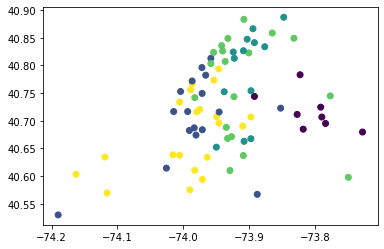

0.17248280953603598


In [33]:
# nyc_X = np.vstack((precinct_long, precinct_lat, nyc_violent, nyc_non_violent, 
#                    nyc_theft,nyc_traffic, nyc_drugs, nyc_18_24, nyc_25_44, 
#                    nyc_45_64, nyc_lt_18,nyc_males, nyc_females, nyc_business,
#                    nyc_black,nyc_white,nyc_asian_pa,nyc_ai_an)).T

#without victim sex
nyc_X = np.vstack((precinct_long, precinct_lat, nyc_violent, nyc_non_violent, 
                   nyc_theft,nyc_traffic, nyc_drugs, nyc_18_24, nyc_25_44, 
                   nyc_45_64, nyc_lt_18,
                   nyc_black,nyc_white,nyc_asian_pa,nyc_ai_an)).T

# Scale
scaler = StandardScaler()
nyc_X = scaler.fit_transform(nyc_X)

#Cluster
precinct_cluster_model = KMeans(n_clusters = n)
precinct_cluster_model.fit(nyc_X)

precinct_clusters = precinct_cluster_model.labels_
precinct_vic_age_centroids = precinct_cluster_model.cluster_centers_

plt.scatter(precinct_long, precinct_lat, c = precinct_clusters)
plt.show()

#Evaluate with Kmean silhouette score
labels = precinct_cluster_model.labels_
score = silhouette_score(nyc_X,precinct_cluster_model.labels_, metric='euclidean')
print(score)


<h2>Scree plot</h2>

<h3>PCA Dimension reduction</h3>

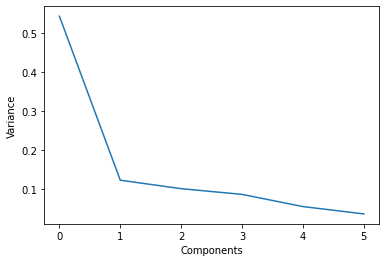

In [34]:
#PCA dimension reduction
pca = PCA(n_components=6)
pca_components = pca.fit_transform(nyc_X)
plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xticks(range(pca.n_components_))
plt.ylabel('Variance')
plt.xlabel('Components')
plt.show()

PCA_components = pd.DataFrame(pca_components)

#set components = 2
c = 2


KMeans N = 3 with PCA components 2


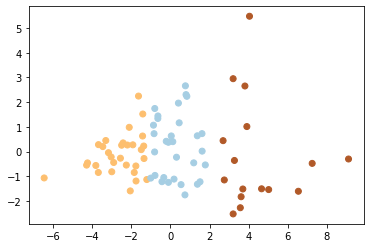

0.3676730693017208


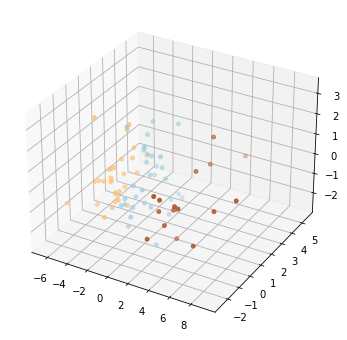

In [35]:
print("\nKMeans N = {} with PCA components {}".format(3, c))
pca_based_model = KMeans(n_clusters=3)
pca_based_model.fit(PCA_components.iloc[:,:c])
pca_clusters = pca_based_model.labels_

plt.scatter(PCA_components[0], PCA_components[1], c = pca_clusters, cmap = plt.cm.Paired)
plt.show()

#with 3 dimensional view

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_components[0],PCA_components[1], PCA_components[2], c=pca_clusters, marker='o', s=15, 
           cmap=plt.cm.Paired)

#evaluation with silhouette score
print(silhouette_score(PCA_components.iloc[:,:c], pca_clusters, metric='euclidean'))


KMeans N = 4 with PCA components 2


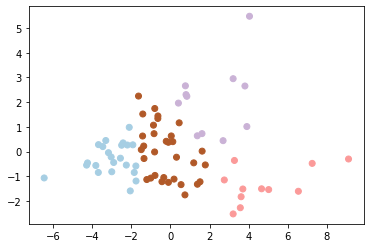

0.3692482085355987


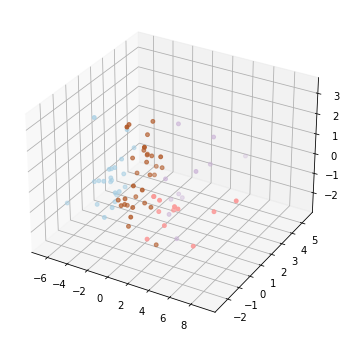

In [36]:
print("\nKMeans N = {} with PCA components {}".format(4, c))
pca_based_model = KMeans(n_clusters=4)
pca_based_model.fit(PCA_components.iloc[:,:c])
pca_clusters = pca_based_model.labels_

plt.scatter(PCA_components[0], PCA_components[1], c = pca_clusters, cmap = plt.cm.Paired)
plt.show()

#with 3 dimensional view

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_components[0],PCA_components[1], PCA_components[2], c=pca_clusters, marker='o', s=15, cmap=plt.cm.Paired)

#evaluation with silhouette score
print(silhouette_score(PCA_components.iloc[:,:c], pca_clusters, metric='euclidean'))


KMeans N = 5 with PCA components = 2


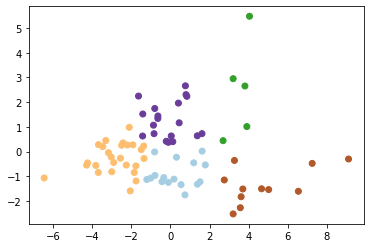

0.39738001763864905


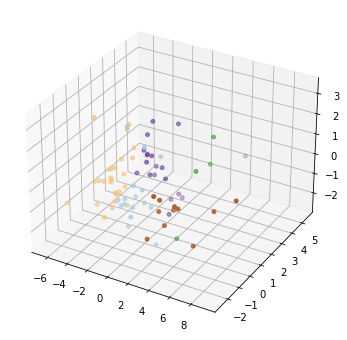

In [37]:
print("\nKMeans N = {} with PCA components = {}".format(5, c))
pca_based_model = KMeans(n_clusters=5)
pca_based_model.fit(PCA_components.iloc[:,:c])
pca_clusters = pca_based_model.labels_

plt.scatter(PCA_components[0], PCA_components[1], c = pca_clusters, cmap = plt.cm.Paired)
plt.show()

#with 3 dimensional view

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PCA_components[0],PCA_components[1], PCA_components[2], c=pca_clusters, marker='o', s=15, cmap=plt.cm.Paired)

#evaluation with silhouette score
print(silhouette_score(PCA_components.iloc[:,:c], pca_clusters, metric='euclidean'))

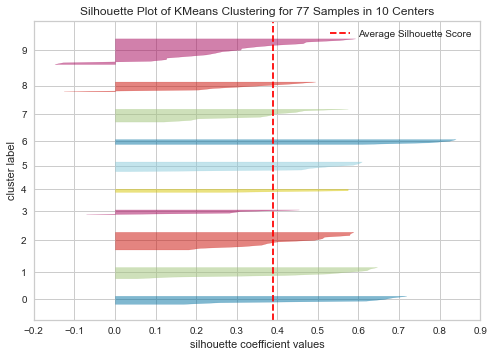

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 77 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
#view with Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer

pca_based_model = KMeans(n_clusters=10)
pca_based_model.fit(PCA_components.iloc[:,:c])

visualizer = SilhouetteVisualizer(pca_based_model, colors='yellowbrick')

visualizer.fit(PCA_components.iloc[:,:c])     
visualizer.show() 